In [1]:
import time
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc, accuracy_score
from sklearn.model_selection import train_test_split
#modified from source to return uncentered ALE instead centered and the std of ale distribution
from alibi.explainers.ale import ALE, plot_ale 
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import warnings
import matplotlib.pyplot as plt
from collections import Counter
warnings.filterwarnings('ignore')
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
pd.set_option('display.max_columns', None)
from sklearn.datasets import load_breast_cancer

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [3]:
def summary_ALE (df, X,y,feautes_names, target_names, classifier, cv):

    seed = 12345
    cv = StratifiedKFold(n_splits=5,random_state=None)
    result = pd.DataFrame(columns=['fold','name', 'ale_0', 'std','max','clas', 'mean', 'mem'])
    ale_values= {}

    for i, (train, test) in enumerate(cv.split(X, y)):
        for m in classifier:
            name_classifier = type(m).__name__
            fold = 1
            ale_values[name_classifier] = {}
            m.fit(X[train], y[train])
        
            proba_fun = m.predict_proba
            proba_ale = ALE(proba_fun, feature_names=feature_names, target_names=target_names)
            proba_exp = proba_ale.explain(X[train])
            plot_ale(proba_exp, features=[2]);
        
            fold = []
            name = []
            ale0_list = []
            std_list = []
            max_list = []
            clas=[]
            coef_list = []
            mean_list = []
            mem_list =[]
        #max(x.min(), x.max(), key=abs)
            for var, j in enumerate(feature_names):
                array = proba_exp['feature_values'][var]
                value = X[train][:,var].mean()
                nearest = find_nearest(array, value)
                pos = np.where(proba_exp['feature_values'][var] == nearest)[0][0]
                j = str(j)
                ale_0 = proba_exp.ale0[var]
                name.append(j)
                ale0_list.append(ale_0)
            
            #uncentered ale values
                ale_values[name_classifier][var] = proba_exp.ale_values[var][:,1] #+ ale_0
                #ale_values[name_classifier][var] = proba_exp.ale0[var][:,1] #+ ale_0
            
                std_list.append(ale_values[name_classifier][var].std())
                max_abs = max(ale_values[name_classifier][var].min(), ale_values[name_classifier][var].max(), key=abs)
                max_list.append(max_abs)
            #print(ale_0)
                mean_list.append((ale_values[name_classifier][var]).mean())
                mem_list.append(ale_values[name_classifier][var][pos])
            
                                   
                if name_classifier == 'LogisticRegression':
                    coef_list.append(m.coef_[0][var])
                else :
                    coef_list.append(m.feature_importances_[var]) 
            
                clas.append(name_classifier)
                fold.append(i)
        
            df = pd.DataFrame(zip(fold, name, ale0_list, std_list,max_list, coef_list, clas, mean_list, mem_list), 
                          columns =['fold','name', 'ale_0', 'std', 'max','coef', 'clas', 'mean', 'mem'])
            result = result.append(df)
    
    return(result)
        

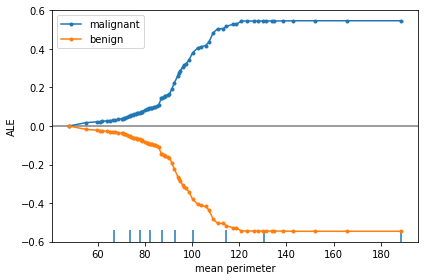

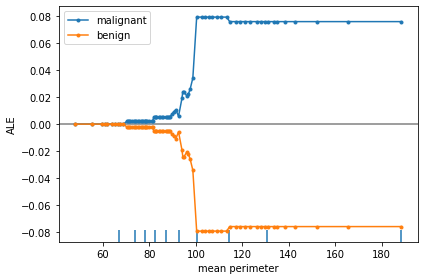

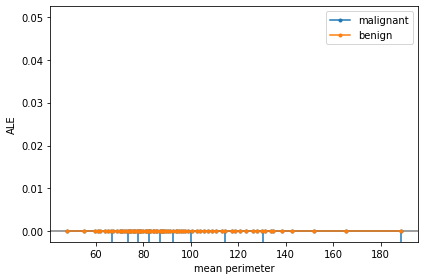

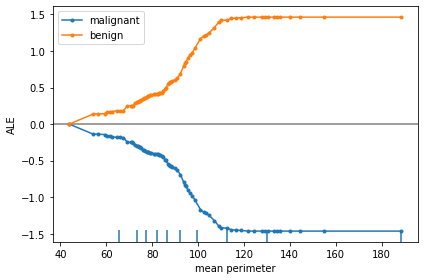

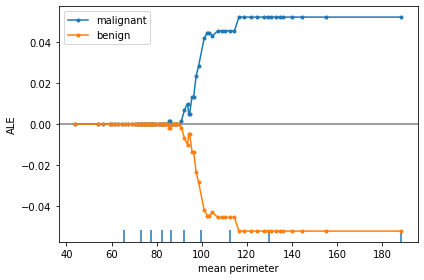

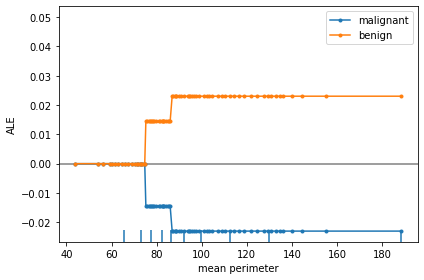

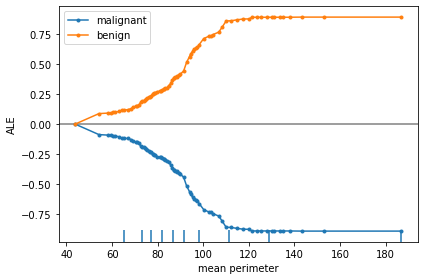

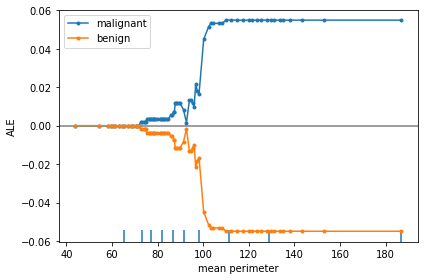

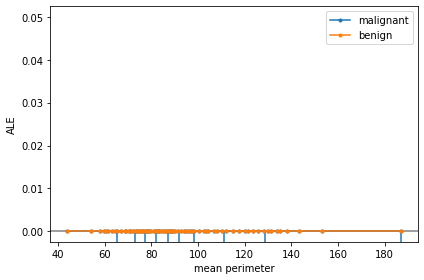

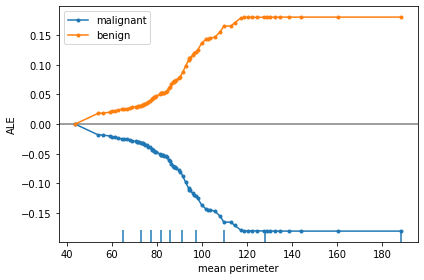

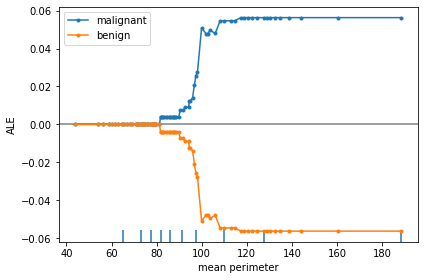

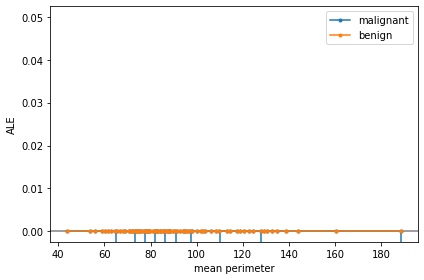

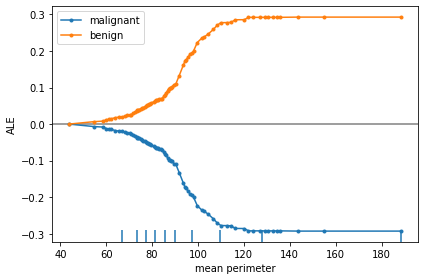

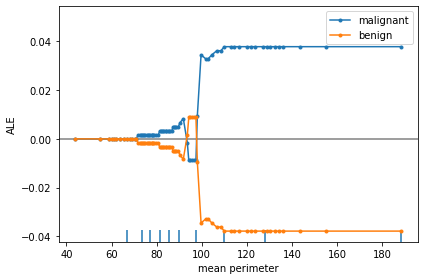

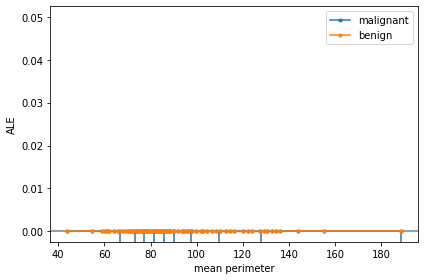

In [4]:
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target
feature_names = cancer.feature_names
target_names = cancer.target_names
classifier = [LogisticRegression(),  RandomForestClassifier(random_state=0), AdaBoostClassifier(random_state=0)]
cv =5
result = summary_ALE(cancer, X,y,feature_names, target_names, classifier, cv)

In [7]:
result[['clas','fold', 'name', 'max','mem','coef', 'std','mean', 'ale_0']]

,clas,fold,name,max,mem,coef,std,mean,ale_0
0,LogisticRegression,0,mean radius,0.660984,0.262766,1.730130,0.241992,0.269065,0.217931
1,LogisticRegression,0,mean texture,0.144355,0.033052,0.160177,0.026188,0.034790,0.020577
2,LogisticRegression,0,mean perimeter,-0.546298,-0.223925,-0.200470,0.201133,-0.231632,0.182996
3,LogisticRegression,0,mean area,0.429026,0.211213,0.012093,0.161697,0.164023,0.145734
4,LogisticRegression,0,mean smoothness,-0.000204,-0.000087,-0.063085,0.000032,-0.000086,0.000025
...,...,...,...,...,...,...,...,...,...
25,LogisticRegression,4,worst compactness,-0.045665,-0.005504,-0.822284,0.006732,-0.006157,0.004578
26,LogisticRegression,4,worst concavity,-0.043236,-0.008563,-0.932137,0.008603,-0.009085,0.006897
27,LogisticRegression,4,worst concave points,-0.003009,-0.000996,-0.295487,0.000927,-0.001075,0.000831
28,LogisticRegression,4,worst symmetry,-0.006317,-0.001463,-0.266836,0.000804,-0.001526,0.000511


In [14]:
np.mean(np.abs(result[(result.clas=="LogisticRegression")&(result.name=="mean perimeter")]['max'].values)-)

-0.3254100426208229

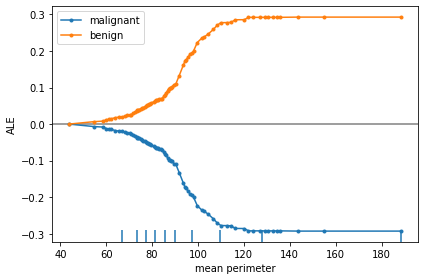

In [13]:
#plot some Centered ALE 
plot_ale(proba_exp, features=[2]);

In [9]:
proba_exp['ale_values'][1:]

[array([[ 0.        ,  0.        ],
        [-0.00358654,  0.00358654],
        [-0.00446855,  0.00446855],
        [-0.00482416,  0.00482416],
        [-0.00591769,  0.00591769],
        [-0.00611824,  0.00611824],
        [-0.01176498,  0.01176498],
        [-0.01578348,  0.01578348],
        [-0.01661765,  0.01661765],
        [-0.01756963,  0.01756963],
        [-0.01802603,  0.01802603],
        [-0.02159454,  0.02159454],
        [-0.02223654,  0.02223654],
        [-0.02247486,  0.02247486],
        [-0.02296848,  0.02296848],
        [-0.0264747 ,  0.0264747 ],
        [-0.02783124,  0.02783124],
        [-0.02865411,  0.02865411],
        [-0.03059391,  0.03059391],
        [-0.03084229,  0.03084229],
        [-0.03136829,  0.03136829],
        [-0.03182058,  0.03182058],
        [-0.03218403,  0.03218403],
        [-0.04016394,  0.04016394],
        [-0.04218055,  0.04218055],
        [-0.04394061,  0.04394061],
        [-0.04665273,  0.04665273],
        [-0.04804047,  0.048

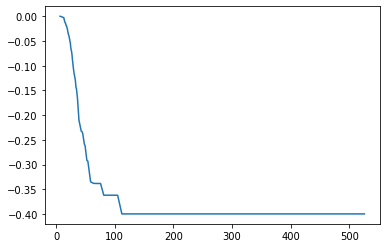

In [11]:
#Plot uncentered ALE
#plt.plot(proba_exp['feature_values'][2],ale_values['RandomForestClassifier'][2])
#plt.plot(proba_exp['feature_values'][13],ale_values['AdaBoostClassifier'][13])
plt.plot(proba_exp['feature_values'][13],ale_values['LogisticRegression'][13])

In [16]:
feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

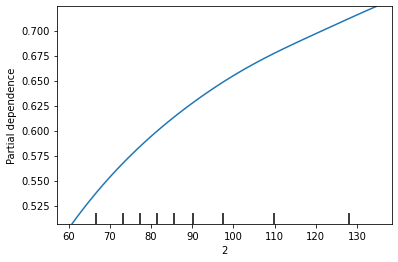

In [12]:
#Partial plots for some features
display = plot_partial_dependence(
           m, X[train], [2],
       n_jobs=5, grid_resolution=100, random_state=0
)

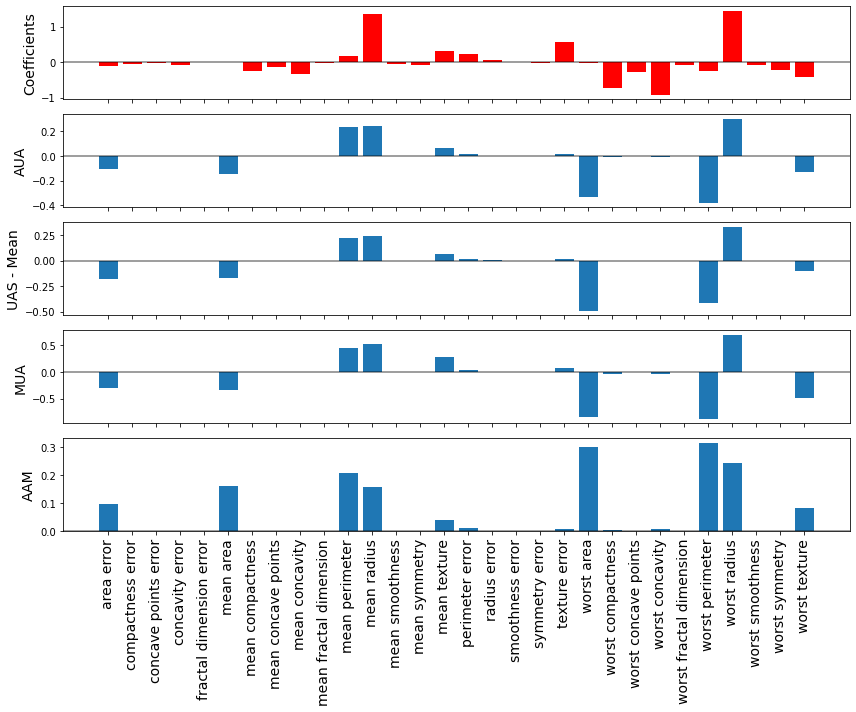

In [5]:
grouped = result.groupby(['name', 'clas'])['max','mean','mem','coef', 'std', 'ale_0'].mean().reset_index()
lr = grouped[grouped.clas=="LogisticRegression"]
lrcoefg = lr.sort_values(by='coef', key=abs,  ascending=False)
lrmeasures = lr.loc[lr.name.isin(lrcoefg.name.values)]
#meang= lr.sort_values(by='mean', key=abs,  ascending=False).head(10)[['name','mean', 'std']]
#lrmemg = lr.sort_values(by='mem', key=abs,  ascending=False).head(10)[['name','mem', 'std']]

fig, axs = plt.subplots(5, 1, figsize=(12, 10), sharex = True)
#plt.xticks(rotation=45)
axs[0].bar(lrmeasures['name'],lrmeasures['coef'], color="red")
axs[1].bar(lrmeasures['name'], lrmeasures['mean'])
#axs[2].bar(meang['name'], meang['mean'])
axs[2].bar(lrmeasures['name'], lrmeasures['mem'])
axs[3].bar(lrmeasures['name'], lrmeasures['max'])
axs[4].bar(lrmeasures['name'], lrmeasures['ale_0'])


axs[0].set_xticklabels(lrmeasures.name,rotation=90)
axs[0].set_ylabel('Coefficients',fontsize=14)
axs[1].set_xticklabels(lrmeasures.name,rotation=90)
axs[1].set_ylabel('AUA',fontsize=14)
axs[2].set_xticklabels(lrmeasures.name,rotation=90)
axs[2].set_ylabel('UAS - Mean',fontsize=14)
axs[3].set_xticklabels(lrmeasures.name,rotation=90)
axs[3].set_ylabel('MUA',fontsize=14)
axs[4].set_xticklabels(lrmeasures.name,rotation=90,fontsize=14)
axs[4].set_ylabel('AAM',fontsize=14)

for i in range(5):
    axs[i].axhline(y=0, color='black', linestyle='-', alpha=0.5)

    fig.tight_layout()
plt.show()

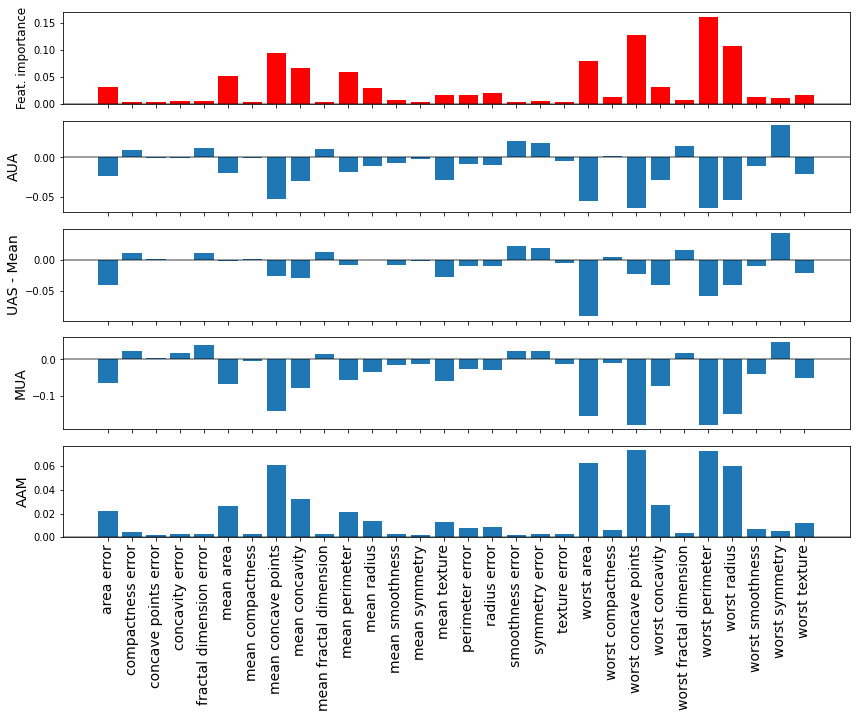

In [6]:
lr = grouped[grouped.clas=="RandomForestClassifier"]
lrcoefg = lr.sort_values(by='coef', key=abs,  ascending=False)
lrmeasures = lr.loc[lr.name.isin(lrcoefg.name.values)]
#meang= lr.sort_values(by='mean', key=abs,  ascending=False).head(10)[['name','mean', 'std']]
#lrmemg = lr.sort_values(by='mem', key=abs,  ascending=False).head(10)[['name','mem', 'std']]

fig, axs = plt.subplots(5, 1, figsize=(12, 10), sharex = True)
#plt.xticks(rotation=45)
axs[0].bar(lrmeasures['name'],lrmeasures['coef'], color="red")
axs[1].bar(lrmeasures['name'], lrmeasures['mean'])
#axs[2].bar(meang['name'], meang['mean'])
axs[2].bar(lrmeasures['name'], lrmeasures['mem'])
axs[3].bar(lrmeasures['name'], lrmeasures['max'])
axs[4].bar(lrmeasures['name'], lrmeasures['ale_0'])


axs[0].set_xticklabels(lrmeasures.name,rotation=90)
axs[0].set_ylabel('Feat. importance',fontsize=12)
axs[1].set_xticklabels(lrmeasures.name,rotation=90)
axs[1].set_ylabel('AUA',fontsize=14)
axs[2].set_xticklabels(lrmeasures.name,rotation=90)
axs[2].set_ylabel('UAS - Mean',fontsize=14)
axs[3].set_xticklabels(lrmeasures.name,rotation=90)
axs[3].set_ylabel('MUA',fontsize=14)
axs[4].set_xticklabels(lrmeasures.name,rotation=90,fontsize=14)
axs[4].set_ylabel('AAM',fontsize=14)

for i in range(5):
    axs[i].axhline(y=0, color='black', linestyle='-', alpha=0.5)

    fig.tight_layout()
plt.show()

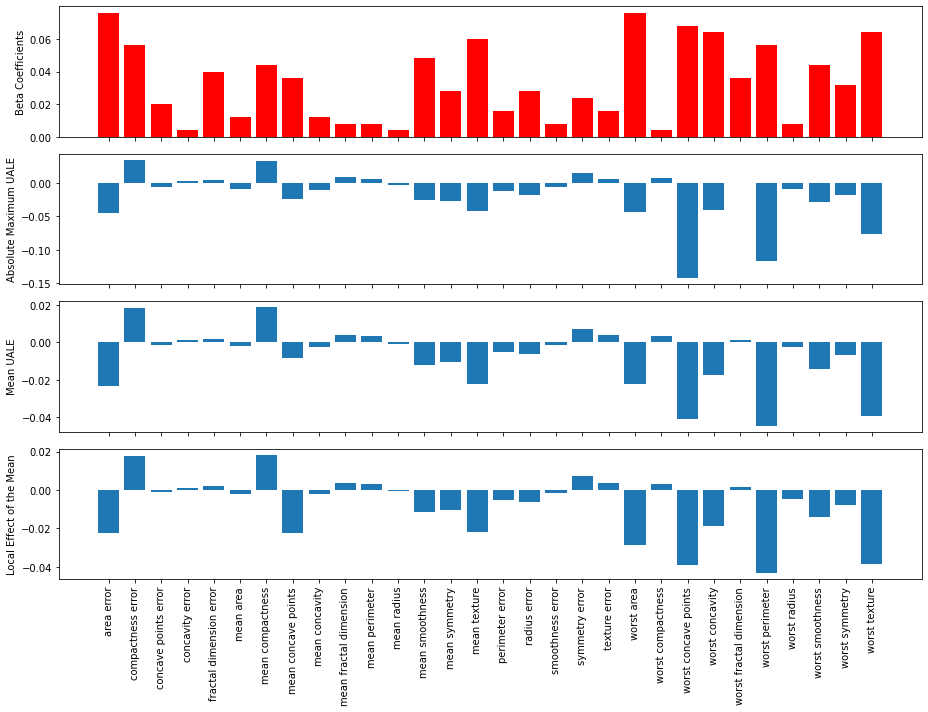

In [16]:
ab = grouped[grouped.clas=="AdaBoostClassifier"]
abcoefg = ab.sort_values(by='coef', key=abs,  ascending=False)
abmeasures = ab.loc[ab.name.isin(abcoefg.name.values)]
#meang= lr.sort_values(by='mean', key=abs,  ascending=False).head(10)[['name','mean', 'std']]
#lrmemg = lr.sort_values(by='mem', key=abs,  ascending=False).head(10)[['name','mem', 'std']]

fig, axs = plt.subplots(4, 1, figsize=(13, 10), sharex = True)
#plt.xticks(rotation=45)
axs[0].bar(abmeasures['name'],abmeasures['coef'], color="red")
axs[1].bar(abmeasures['name'], abmeasures['max'])
#axs[2].bar(meang['name'], meang['mean'])
axs[2].bar(abmeasures['name'], abmeasures['mean'])
axs[3].bar(abmeasures['name'], abmeasures['mem'])

axs[0].set_xticklabels(abmeasures.name,rotation=90)
axs[0].set_ylabel('Permutation FI')
axs[1].set_xticklabels(abmeasures.name,rotation=90)
axs[1].set_ylabel('Absolute Maximum UALE')
axs[2].set_xticklabels(abmeasures.name,rotation=90)
axs[2].set_ylabel('Mean UALE')
axs[3].set_xticklabels(abmeasures.name,rotation=90)
axs[3].set_ylabel('Local Effect of the Mean')
#axs[0][2].set_xticklabels(lrmeasures.name,rotation=90)

fig
fig.tight_layout()
plt.show()

In [4]:
DATA_RAW = pd.read_csv('ALL_SCHOOLS_v2.csv')


In [5]:
controls = ["CO_ANO", 'IN_TP_ESCOLA']
school = [

                          'IN_LABORATORIO_INFORMATICA',
                          'IN_LABORATORIO_CIENCIAS',
                          'IN_SALA_ATENDIMENTO_ESPECIAL',
                          'IN_BIBLIOTECA',
                          'IN_SALA_LEITURA',
                          'IN_BANHEIRO',
                          'IN_BANHEIRO_PNE',
                          'QT_SALAS_UTILIZADAS',
                          'QT_EQUIP_TV',
                          'QT_EQUIP_DVD',
                          'QT_EQUIP_COPIADORA',
                          'QT_EQUIP_IMPRESSORA',
                          'QT_COMP_ALUNO',
                          'IN_BANDA_LARGA',
                          'QT_FUNCIONARIOS',
                          'IN_ALIMENTACAO',
                          'IN_SALA_PROFESSOR',
                          'IN_COZINHA',
                          'IN_EQUIP_PARABOLICA',
                          'IN_QUADRA_ESPORTES',
                          'IN_ATIV_COMPLEMENTAR',
                          'QT_MATRICULAS',     
                          
                         ]

teacher = ['TITULACAO', 'IN_FORM_DOCENTE','NU_LICENCIADOS', 
              'NU_CIENCIA_NATUREZA','NU_CIENCIAS_HUMANAS', 'NU_LINGUAGENS_CODIGOS', 'NU_MATEMATICA',  'NU_ESCOLAS']

student =['RENDA_PERCAPITA','EDU_PAI', 'EDU_MAE','NU_IDADE']

non_actionable = ['TP_COR_RACA_1.0','TP_SEXO',
                        'TP_COR_RACA_2.0', 'TP_COR_RACA_3.0', 'TP_COR_RACA_4.0',
                        'TP_COR_RACA_5.0']

target = ['NU_NOTA_GERAL']


In [6]:
## Dropping hight mode frequencies (upper 90%)
def mode_high_frequencie(df):
    columns_dropped = []
    ammount=0
    before= df.shape[1]
    #print("Number of features: ", before)
    for i in df:
        mode = df[i].mode()[0]
        threshold = 0.9
        count = df[(df[i]== mode)].shape[0]
        freq = count/df.shape[0]
        if freq >= threshold:
            ammount +=1
            print("drop out", [i], "mode = ", mode )
            #df.drop([i], inplace = True, axis=1)
            columns_dropped.append(i)
            
    print("Total Dropped: ",ammount)
    print ("Remainning: ", before-ammount)  
    return(columns_dropped)

In [7]:
def scaler (df):
    scaler = MinMaxScaler()
    x = df.values
    x_scaled = scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled, columns = df.columns)
    return (df)

In [8]:
def clip_tail(df):
    quantitative = df[(df.nunique() > 2).index[(df.nunique() > 2)]].columns.to_list()
    #print(len(quantitative)
    df[quantitative]=df[quantitative].apply(lambda x: x.clip(upper = (np.percentile(x, 97.5))))
    df[quantitative]=df[quantitative].apply(lambda x: x.clip(lower = (np.percentile(x, 2.5))))
    return(df)

In [9]:
def build_target(df):
    df['TARGET'] = pd.qcut (df.NU_NOTA_GERAL, 4, labels = [1,2,3,4]).map(lambda x : 0 if x!=4 else 1) 
    #print((df.TARGET==0).sum()/(df.TARGET.count())*100, '% lowers quartis')
    return df['TARGET']

In [10]:
#DATA = DATA_RAW[DATA_RAW.CO_ANO==2016]
DATA=DATA_RAW[DATA_RAW.IN_TP_ESCOLA=='Municipal+Estadual']

In [11]:
#Only elementary infrastructure schools
#print(DF)
DATA= DATA.loc[(DATA.IN_AGUA_INEXISTENTE == 0) & (DATA.IN_ENERGIA_INEXISTENTE == 0) & (DATA.IN_ESGOTO_INEXISTENTE == 0)]

In [12]:
QT_to_IN = ['QT_EQUIP_DVD', 'QT_EQUIP_COPIADORA', 'QT_EQUIP_IMPRESSORA', 'QT_EQUIP_TV']
conds = [DATA[QT_to_IN].values == 0 , DATA[QT_to_IN].values > 0]
choices = [0, 1]
DATA[QT_to_IN] = pd.DataFrame(np.select(conds, choices), index=DATA[QT_to_IN].index, columns=DATA[QT_to_IN].columns)
#DF[QT_to_IN] = DF[QT_to_IN].astype('category')

In [13]:
DATA.head()

,Unnamed: 0,CO_ANO,CO_ESCOLA,NU_IDADE,TP_SEXO,TP_ST_CONCLUSAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,EDU_PAI,EDU_MAE,QT_PESSOAS_CASA,RENDA_MENSAL,NU_NOTA_GERAL,CO_MUNICIPIO,CO_UF,CO_DEPENDENCIA_ADM,IN_AGUA_INEXISTENTE,IN_ESGOTO_INEXISTENTE,IN_ENERGIA_INEXISTENTE,IN_LABORATORIO_INFORMATICA,IN_LABORATORIO_CIENCIAS,IN_SALA_ATENDIMENTO_ESPECIAL,IN_BIBLIOTECA,IN_SALA_LEITURA,IN_BANHEIRO,IN_BANHEIRO_PNE,QT_SALAS_UTILIZADAS,QT_EQUIP_TV,QT_EQUIP_DVD,QT_EQUIP_COPIADORA,QT_EQUIP_IMPRESSORA,QT_COMP_ALUNO,IN_INTERNET,IN_BANDA_LARGA,QT_FUNCIONARIOS,IN_ALIMENTACAO,IN_COMUM_MEDIO_MEDIO,IN_COMUM_MEDIO_INTEGRADO,IN_COMUM_MEDIO_NORMAL,IN_SALA_PROFESSOR,IN_QUADRA_ESPORTES,IN_COZINHA,IN_EQUIP_PARABOLICA,IN_ATIV_COMPLEMENTAR,QT_MATRICULAS,TITULACAO,NU_CIENCIA_NATUREZA,NU_CIENCIAS_HUMANAS,NU_LINGUAGENS_CODIGOS,NU_MATEMATICA,NU_TEACHERS_DOMAIN,NU_ESCOLAS,NU_LICENCIADOS,NU_TEACHERS,IN_FORM_DOCENTE,IN_INFRA_NENHUMA,IN_INFRA_ELEMENTAR,IN_INFRA_BASICA,IN_INFRA_ADEQUADA,IN_INFRA_AVANCADA,IN_TP_ESCOLA,RENDA_NUM,RENDA_PERCAPITA,STD_MEAN_ESCOLA,DIVERSIDADE,TP_COR_RACA_0.0,TP_COR_RACA_1.0,TP_COR_RACA_2.0,TP_COR_RACA_3.0,TP_COR_RACA_4.0,TP_COR_RACA_5.0
0,0,2009,33052182.0,18.380952,0.333333,2.0,459.980952,462.657143,482.566667,447.776190,583.333333,1.285714,1.571429,2.904762,1.904762,487.262857,3305752,33,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,16.0,1,1,1,1,10.0,1.0,1.0,110.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,35.666667,0.074074,0.145833,0.229167,0.437500,0.187500,48.0,1.291667,0.979167,48,0.780303,0,0.0,0.0,1.0,0.0,Municipal+Estadual,1558.5,540.115079,53.195726,1.000000,0.238095,0.142857,0.047619,0.523810,0.000000,0.047619
1,21,2009,33125813.0,18.406977,0.383721,2.0,502.117442,499.289535,517.436047,490.169767,622.965116,1.639535,2.279070,2.813953,2.313953,526.395581,3304300,33,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,10.0,1,1,1,1,10.0,1.0,1.0,128.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,32.857143,0.187500,0.222222,0.277778,0.361111,0.138889,36.0,1.472222,1.000000,35,0.862121,0,0.0,0.0,1.0,0.0,Municipal+Estadual,1558.5,893.519864,60.982442,0.972222,0.046512,0.360465,0.081395,0.488372,0.023256,0.000000
11,1321,2009,33028958.0,18.375000,0.357143,2.0,497.108929,482.655357,496.044643,464.610714,599.107143,1.928571,2.250000,2.642857,2.482143,507.905357,3305505,33,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,10.0,1,1,1,1,12.0,1.0,1.0,90.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,31.571429,0.083333,0.195652,0.217391,0.434783,0.152174,46.0,1.261905,1.000000,40,0.738203,0,0.0,0.0,1.0,0.0,Municipal+Estadual,1558.5,1158.825149,61.748580,0.869565,0.035714,0.464286,0.053571,0.357143,0.071429,0.017857
13,1439,2009,33035466.0,18.547619,0.392857,2.0,525.742857,517.580952,527.122619,517.113095,609.226190,2.083333,2.369048,2.702381,2.345238,539.357143,3306107,33,2,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,24.0,1,1,1,1,30.0,1.0,1.0,160.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,30.400000,0.088889,0.157895,0.289474,0.381579,0.171053,76.0,1.513158,1.000000,76,0.803662,0,0.0,0.0,0.0,1.0,Municipal+Estadual,3636.5,961.178075,69.117702,1.000000,0.047619,0.511905,0.119048,0.273810,0.035714,0.011905
14,1523,2009,33033145.0,18.531250,0.281250,2.0,494.975000,485.103125,510.256250,477.531250,612.500000,1.843750,2.250000,2.875000,2.718750,516.073125,3306305,33,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,8.0,1,1,1,1,10.0,1.0,1.0,80.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,39.000000,0.173077,0.227273,0.227273,0.431818,0.113636,44.0,1.545455,0.950000,40,0.799242,0,0.0,0.0,1.0,0.0,Municipal+Estadual,3636.5,1183.756510,55.035321,0.909091,0.093750,0.375000,0.218750,0.250000,0.062500,0.000000


In [14]:
print('school',len(school))
print('teacher',len(teacher))
print('student',len(student))
print('non_actionable',len(non_actionable))
independents =  teacher + student + non_actionable + school
DATA = DATA[controls + independents +  target]

school 22
teacher 8
student 4
non_actionable 6


In [15]:
classifier = [RandomForestClassifier(random_state=0), AdaBoostClassifier(random_state=0)]

In [16]:
#def summary_ALE_BR_Education (df,feature_names, classifier):
seed = 12345
cv = StratifiedKFold(n_splits=2,random_state=None)
result = pd.DataFrame(columns=['fold','year','name', 'ale_0', 'std', 'max','coef', 'clas', 'mean', 'mem'])
ale_values= {}
df, feature_names, classifier = DATA,independents, classifier
df_year = df.copy()
for year in df_year.CO_ANO.unique().tolist():
        df = df_year[df_year.CO_ANO == year]
        bad_columns = mode_high_frequencie(df[feature_names])
        feature_names = df[feature_names].loc[:, ~df[feature_names].columns.isin(
        bad_columns)].columns.to_list()
        df = clip_tail(df)
        y = build_target(df).to_numpy()
        X= df[feature_names].to_numpy()
    
        for i, (train, test) in enumerate(cv.split(X, y)):
            for m in classifier:
                name_classifier = type(m).__name__
                fold = 1
                ale_values[name_classifier] = {}
                m.fit(X[train], y[train])
        
                proba_fun = m.predict_proba
                proba_ale = ALE(proba_fun, feature_names=feature_names, target_names=['TARGET'])
                proba_exp = proba_ale.explain(X[train])
                #plot_ale(proba_exp, features=[2]);
        
                year_list = []
                fold = []
                name = []
                ale0_list = []
                std_list = []
                max_list = []
                clas=[]
                coef_list = []
                mean_list = []
                mem_list =[]
        #max(x.min(), x.max(), key=abs)
                for var, j in enumerate(feature_names):
                    array = proba_exp['feature_values'][var]
                    value = X[train][:,var].mean()
                    nearest = find_nearest(array, value)
                    pos = np.where(proba_exp['feature_values'][var] == nearest)[0][0]
                    j = str(j)
                    ale_0 = proba_exp.ale0[var]
                    name.append(j)
                    ale0_list.append(ale_0)
            
            #uncentered ale values
                    ale_values[name_classifier][var] = proba_exp.ale_values[var][:,1] #+ ale_0
                #ale_values[name_classifier][var] = proba_exp.ale0[var][:,1] #+ ale_0
            
                    std_list.append(ale_values[name_classifier][var].std())
                    max_abs = max(ale_values[name_classifier][var].min(), ale_values[name_classifier][var].max(), key=abs)
                    max_list.append(max_abs)
            #print(ale_0)
                    mean_list.append((ale_values[name_classifier][var]).mean())
                    mem_list.append(ale_values[name_classifier][var][pos])
            
                                   
                    if name_classifier == 'LogisticRegression':
                        coef_list.append(m.coef_[0][var])
                    else :
                        coef_list.append(m.feature_importances_[var]) 
            
                    clas.append(name_classifier)
                    fold.append(i)
                    year_list.append(year)
        
                df = pd.DataFrame(zip(fold, year_list,name, ale0_list, std_list,max_list, coef_list, clas, mean_list, mem_list), 
                          columns =['fold','year','name', 'ale_0', 'std', 'max','coef', 'clas', 'mean', 'mem'])
                result = result.append(df)
    
#return(result)
        
        
        

drop out ['IN_LABORATORIO_INFORMATICA'] mode =  1.0
drop out ['IN_BANHEIRO'] mode =  1.0
drop out ['QT_EQUIP_TV'] mode =  1
drop out ['QT_EQUIP_DVD'] mode =  1
drop out ['QT_EQUIP_IMPRESSORA'] mode =  1
drop out ['IN_ALIMENTACAO'] mode =  1.0
drop out ['IN_SALA_PROFESSOR'] mode =  1.0
drop out ['IN_COZINHA'] mode =  1.0
Total Dropped:  8
Remainning:  32
Total Dropped:  0
Remainning:  32
drop out ['IN_QUADRA_ESPORTES'] mode =  1.0
Total Dropped:  1
Remainning:  31
Total Dropped:  0
Remainning:  31
Total Dropped:  0
Remainning:  31
Total Dropped:  0
Remainning:  31
Total Dropped:  0
Remainning:  31
Total Dropped:  0
Remainning:  31
Total Dropped:  0
Remainning:  31
Total Dropped:  0
Remainning:  31
Total Dropped:  0
Remainning:  31


In [23]:
result.to_csv('result_paperII.csv')

In [ ]:
p = result.loc[result.clas == 'LogisticRegression']
p = result.groupby(['name', 'year'])['max'].mean().reset_index()

In [40]:
p1 = p[p.name.isin(student)].assign(grupo='Student')
p2 = p[p.name.isin(school)].assign(grupo='School')
p3 = p[p.name.isin(teacher)].assign(grupo='Teacher')
p4 = p[p.name.isin(non_actionable)].assign(grupo='Non_actionabale')
histo = pd.concat([p1,p2,p3,p4])

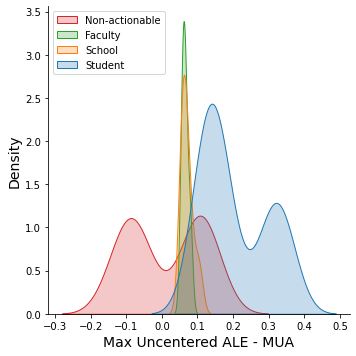

In [83]:
import seaborn as sns
ds = histo[abs(histo['max'])>0.05]
g=sns.displot(ds, x="max", hue="grupo", kind = 'kde',   fill=True, legend=False)
g.set_axis_labels("Max Uncentered ALE - MUA", "Density",fontsize=14)
plt.legend( loc='upper left', labels=['Non-actionable', 'Faculty', "School", "Student"])

#sns.displot(histo, x="max", hue="grupo", kind = 'kde',   fill=True)